[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Wp-Zhang/HandyRec/blob/master/examples/DIN/DIN.ipynb)

> This notebook runs DIN on MovieLens1M dataset. We'll use DSSM for generating candidates and DIN for ranking these candidates.

> Only movies with ratings larger than 3 are treated as 'positive' samples for each user. Every last 10 'positive' movies of each user are held out for testing.

**Download dataset and install packages**

In [1]:
! git clone https://github.com/Wp-Zhang/HandyRec.git
! cd HandyRec && python setup.py install
! pip install faiss-gpu

Cloning into 'HandyRec'...
remote: Enumerating objects: 2098, done.
remote: Counting objects: 100% (295/295), done.
remote: Compressing objects: 100% (206/206), done.
remote: Total 2098 (delta 131), reused 194 (delta 87), pack-reused 1803
Receiving objects: 100% (2098/2098), 24.43 MiB | 17.05 MiB/s, done.
Resolving deltas: 100% (885/885), done.
running install
running bdist_egg
running egg_info
creating handyrec.egg-info
writing handyrec.egg-info/PKG-INFO
writing dependency_links to handyrec.egg-info/dependency_links.txt
writing requirements to handyrec.egg-info/requires.txt
writing top-level names to handyrec.egg-info/top_level.txt
writing manifest file 'handyrec.egg-info/SOURCES.txt'
adding license file 'LICENSE'
writing manifest file 'handyrec.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/handyrec
copying handyrec/config.py -> build/lib/handyrec
copying handyrec/

In [1]:
! wget https://files.grouplens.org/datasets/movielens/ml-1m.zip -O ./ml-1m.zip
! unzip -o ml-1m.zip

--2022-05-24 17:47:12--  https://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘./ml-1m.zip’

./ml-1m.zip         100%[===================>]   5.64M  3.41MB/s    in 1.7s    

2022-05-24 17:47:15 (3.41 MB/s) - ‘./ml-1m.zip’ saved [5917549/5917549]

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


**Import relative packages**

In [2]:
from handyrec.data.movielens import MovielensDataHelper
from handyrec.data.utils import gen_sequence
from handyrec.data import PointWiseDataset

from handyrec.models.ranking import DIN
from handyrec.config import ConfigLoader
from handyrec.data.metrics import map_at_k, recall_at_k
from handyrec.models.utils import search_embedding

import tensorflow as tf
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.utils import plot_model
import numpy as np
import pandas as pd
import gc

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
BATCH_SIZE = 2**12
NEPOCH = 50

TEST_NUM = 10
VALID_RATIO = 0.1
NEG_NUM = 10

**Load MovieLens1M data**

In [5]:
retrieve_dh = MovielensDataHelper('./ml-1m/')
data = retrieve_dh.get_clean_data(sparse_features=['gender','occupation','zip','age','year'])
data['inter']['hist_movie'] = gen_sequence(data['inter'], 'user_id', 'movie_id', seq_len=40)

Generate movie_id sequence: 100%|██████████| 6040/6040 [00:12<00:00, 488.93it/s]


## Prepare data for ranking

In [6]:
# * Use pre-trained embeddings and Faiss to generate candidates
user_embs = np.load("./HandyRec/examples/DSSM/DSSM_user_embd.npy")
item_embs = np.load("./HandyRec/examples/DSSM/DSSM_item_embd.npy")
user_ids = np.load("./HandyRec/examples/DSSM/user_ids.npy")

test_candidates = search_embedding(
    32, item_embs, user_embs, data["item"]["movie_id"].values, 100, gpu=True
)

test_candidates = {user_ids[i] : test_candidates[i] for i in range(len(user_ids))}

In [7]:
user_features = ['user_id', 'gender', 'occupation', 'zip', 'age']
item_features = ['movie_id', 'year', 'genres']
inter_features = ['hist_movie']

In [8]:
ranking_dataset = PointWiseDataset(
    "RankingDataset",
    task="ranking",
    data=data,
    uid_name="user_id",
    iid_name="movie_id",
    inter_name="interact",
    time_name="timestamp",
    threshold=4,
)

ranking_dataset.train_test_split(TEST_NUM)
ranking_dataset.negative_sampling(NEG_NUM)
ranking_dataset.train_valid_split(VALID_RATIO)
ranking_dataset.gen_dataset(user_features, item_features, inter_features, test_candidates)

Save inter features: 100%|██████████| 2/2 [00:36<00:00, 18.23s/it]


In [9]:
train_data, valid_data, test_data, test_label = ranking_dataset.load_dataset(
    user_features, item_features, inter_features, BATCH_SIZE*2
)

Load inter features: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


In [12]:
feature_dim = ranking_dataset.get_feature_dim(user_features, item_features, [])
feature_dim["genre_id"] = 19

## Train rank model and predict

In [13]:
cfg = ConfigLoader("./HandyRec/examples/DIN/DIN_cfg.yaml")
feature_groups = cfg.prepare_features(feature_dim, data)

In [14]:
rank_model = DIN(
    feature_groups["item_seq_feat_group"],
    feature_groups["other_feature_group"],
    **cfg.config.Model
)

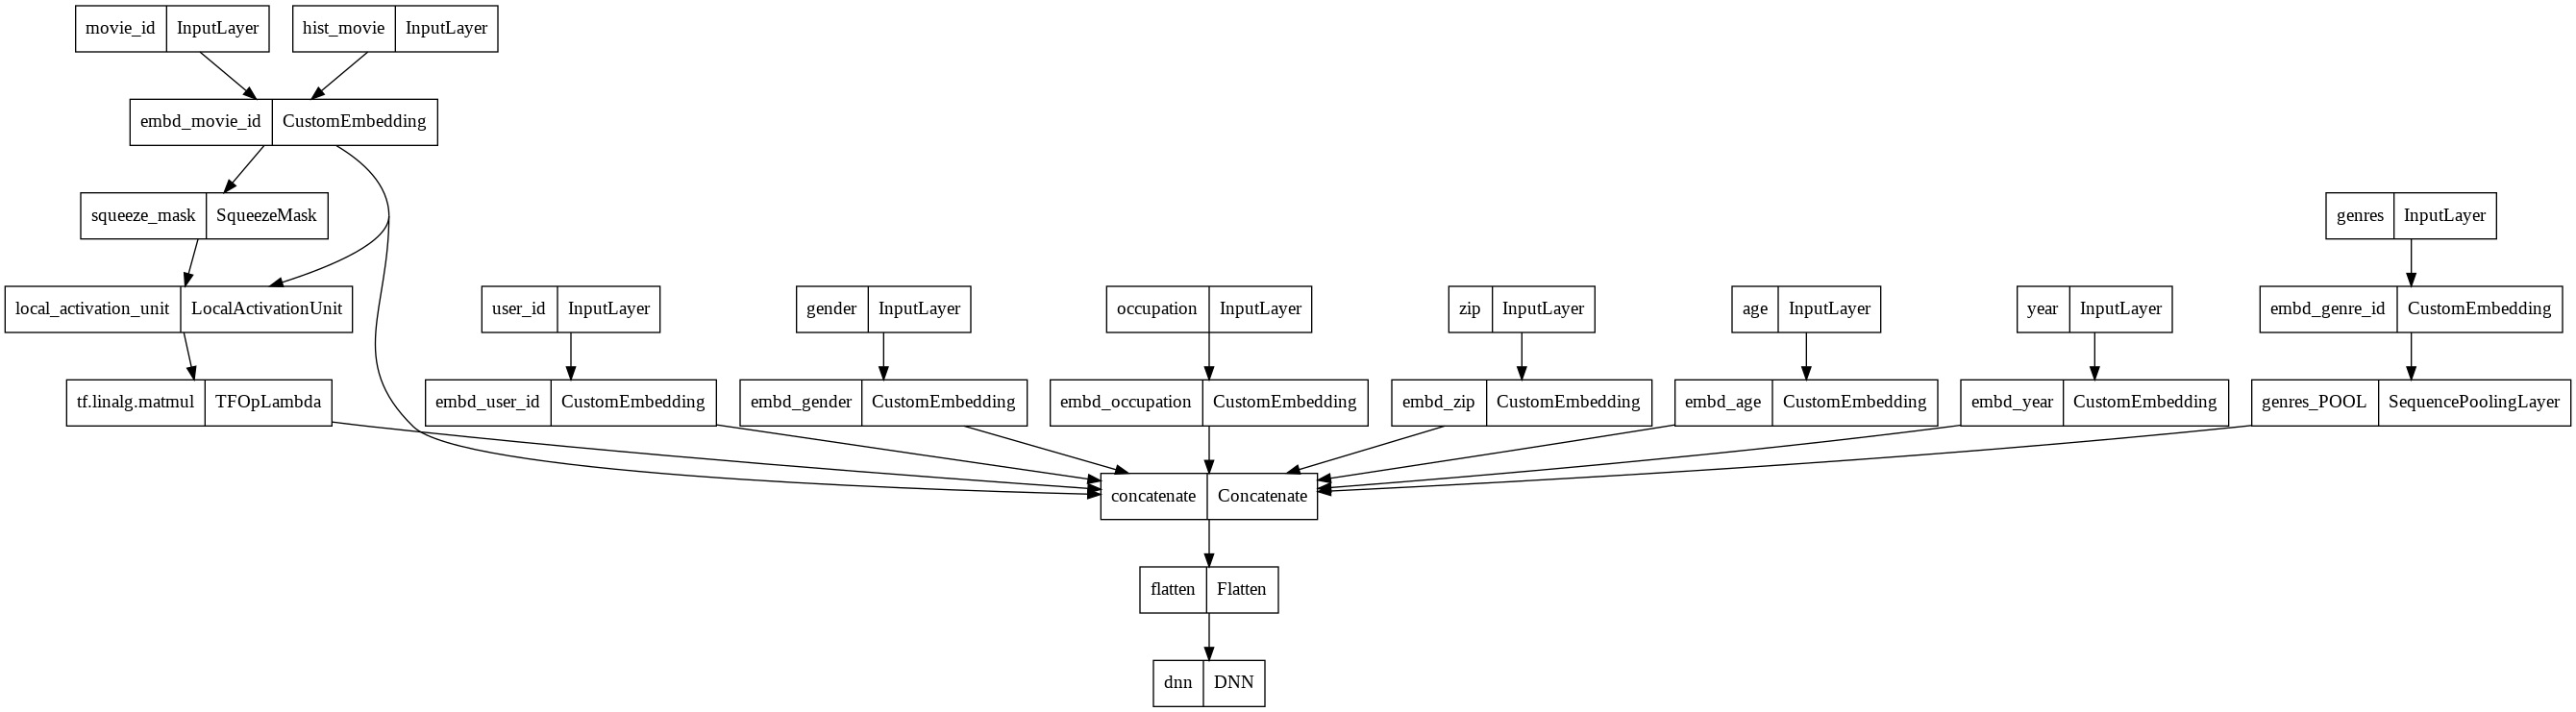

In [15]:
plot_model(rank_model)

In [16]:
rank_model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), loss=binary_crossentropy)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='./rank_checkpoint/',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)
history = rank_model.fit(
    x=train_data, 
    validation_data=valid_data,
    epochs=NEPOCH,
    callbacks=[early_stop,checkpoint]
)

Epoch 1/50
623/623 [==============================] - 109s 163ms/step - loss: 112.2193 - val_loss: 83.3424
Epoch 2/50
623/623 [==============================] - 100s 160ms/step - loss: 71.2016 - val_loss: 60.3602
Epoch 3/50
623/623 [==============================] - 101s 161ms/step - loss: 51.9566 - val_loss: 44.7923
Epoch 4/50
623/623 [==============================] - 100s 160ms/step - loss: 38.9483 - val_loss: 34.3096
Epoch 5/50
623/623 [==============================] - 100s 161ms/step - loss: 29.9585 - val_loss: 26.5681
Epoch 6/50
623/623 [==============================] - 101s 161ms/step - loss: 24.1979 - val_loss: 22.2779
Epoch 7/50
623/623 [==============================] - 101s 161ms/step - loss: 20.1386 - val_loss: 18.5557
Epoch 8/50
623/623 [==============================] - 101s 161ms/step - loss: 16.9857 - val_loss: 15.8870
Epoch 9/50
623/623 [==============================] - 100s 161ms/step - loss: 14.7787 - val_loss: 13.8749
Epoch 10/50
623/623 [========================

In [17]:
rank_model.load_weights('./rank_checkpoint/')

In [18]:
del train_data
gc.collect()

5104

In [19]:
pred = rank_model.predict(test_data, batch_size=BATCH_SIZE)

In [20]:
pred_df = pd.DataFrame(columns=['user_id','movie_id','pred'])
pred_df['user_id'] = test_data['user_id']
pred_df['movie_id'] = test_data['movie_id']
pred_df['pred'] = pred

pred_df = pred_df.sort_values(by=['user_id','pred'], ascending=False).reset_index(drop=True)
pred_df = pred_df.groupby('user_id')['movie_id'].apply(list).reset_index()

In [21]:
test_label_df = pd.DataFrame(columns=['user_id','label'])
test_label_df['user_id'] = pd.Series(test_data['user_id']).drop_duplicates()
test_label_df['label'] = test_label.tolist()

In [22]:
test_label_df = pd.merge(test_label_df, pred_df, on=['user_id'], how='left')

In [23]:
map_at_k(test_label_df['label'], test_label_df['movie_id'], k=10)

0.01204114844204326

In [24]:
recall_at_k(test_label_df['label'], test_label_df['movie_id'], k=10)

0.03381732230288705

In [25]:
recall_at_k(test_label_df['label'], test_label_df['movie_id'], k=100)

0.13670437278406214